In [1]:
"""
notes on multi layer perceptron models
"""

'\nnotes on multi layer perceptron models\n'

# MLP

In [1]:
%matplotlib inline
from typing import Any, cast

import d2l.d2l as d2l
import matplotlib.pyplot as plt
import numpy as np
import structlog
import torch
import torchvision
from IPython.core.interactiveshell import InteractiveShell
from torch import nn
from torch.utils import data
from torchvision import transforms

logger = structlog.get_logger()

InteractiveShell.ast_node_interactivity = "all"  # type:ignore

2026-02-01 19:36:57 [info     ] show relu function            


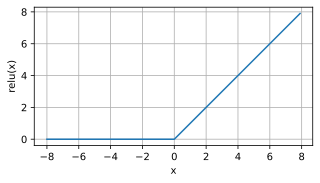

2026-02-01 19:36:57 [info     ] show gradient of relu         


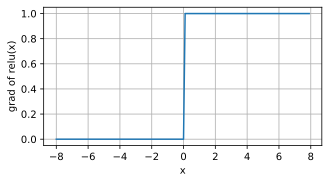

2026-02-01 19:36:57 [info     ] show sigmoid                  


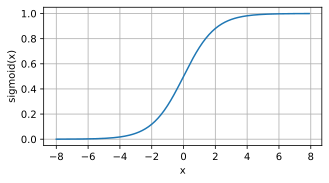

2026-02-01 19:36:58 [info     ] show sigmoid gradient         


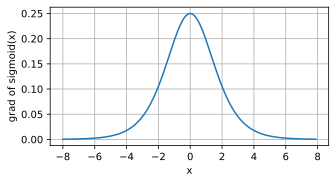

2026-02-01 19:36:58 [info     ] show tanh                     


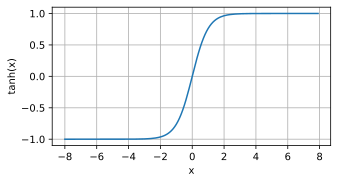

2026-02-01 19:36:58 [info     ] show tanh gradient            


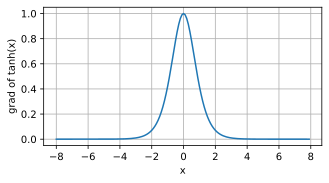

In [11]:
logger.info("show relu function")
x = torch.arange(-8, 8, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), "x", "relu(x)", figsize=(5, 2.5))

plt.show()

logger.info("show gradient of relu")
# torch.ones_like is computing the \partial loss \partial y gradient
# need this because y is a vector.
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, "x", "grad of relu(x)", figsize=(5, 2.5))
plt.show()

logger.info("show sigmoid")
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), "x", "sigmoid(x)", figsize=(5, 2.5))
plt.show()
logger.info("show sigmoid gradient")
_ = x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad.detach(), "x", "grad of sigmoid(x)", figsize=(5, 2.5))
plt.show()

logger.info("show tanh")
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), "x", "tanh(x)", figsize=(5, 2.5))
plt.show()
logger.info("show tanh gradient")
_ = x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad.detach(), "x", "grad of tanh(x)", figsize=(5, 2.5))


* mlp parameter tuning: 

suppose input is 128.

option 1: either shallow but wide,
* set single hidden layer = 64, 128, or 256

option 2: more layer but not too wide
* gradually reduce layer width (think as dimension reduction)
* input 128, hidden layer 1 64, hidden layer 2 32, hidden layer 3 16, hidden layer 4 8, finally output layer.
* sometimes we might make hidden layer 1 > input 128 (initial transform)
    * think as initial dimension projection
* but starting from layer 2, we gradually reduce dimension, not increase dimension
    * starting from layer 2, easier to reduce/refine dimension 
    * but harder to expand from a low dimension to higher dimension (since information already lost)

  

# MLP implementation

* random initialization is necessary
* all set to zero: 
    * zero gradient always. 
* all set to same value 
    * paraemeter might be learn in the same direction too concentrated?

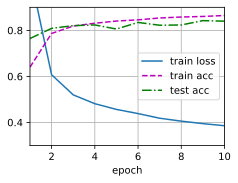

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

n_input, n_output, n_hidden = 784, 10, 256

W1 = nn.Parameter(torch.randn((n_input, n_hidden), requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(n_hidden, requires_grad=True))

W2 = nn.Parameter(torch.randn((n_hidden, n_output), requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(n_output), requires_grad=True)
params = [W1, b1, W2, b2]


def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)


def net(X):
    # flatten
    X = X.reshape((-1, n_input))
    H = relu(X @ W1 + b1)
    return H @ W2 + b2


loss = nn.CrossEntropyLoss(reduction="none")

n_epoch, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, n_epoch, updater)


# MLP implementation using torch

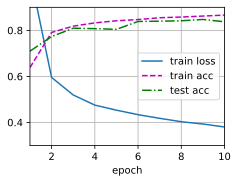

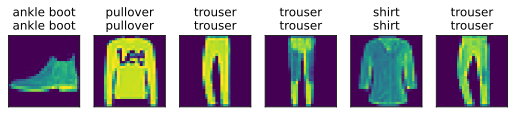

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

n_input, n_output, n_hidden = 784, 10, 256
n_epoch = 10
lr = 0.1

net = nn.Sequential(
    nn.Flatten(), nn.Linear(n_input, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output)
)


def init_weight(m):
    """init weight for given layer"""
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weight)

loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr)

d2l.train_ch3(
    net,
    train_iter,
    test_iter,
    loss=loss,
    updater=trainer,
    n_epoch=n_epoch,
)

d2l.predict_ch3(net, test_iter)


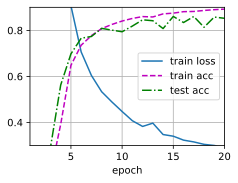

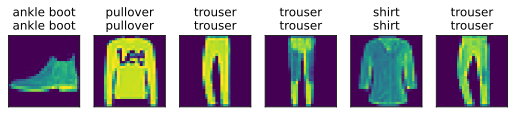

In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

n_input, n_output = 784, 10
n_epoch = 20
lr = 0.2

net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_input, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, n_output),
)


def init_weight(m):
    """init weight for given layer"""
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weight)

loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr)

d2l.train_ch3(
    net,
    train_iter,
    test_iter,
    loss=loss,
    updater=trainer,
    n_epoch=n_epoch,
)

d2l.predict_ch3(net, test_iter)


* in q&a
* very wide signle hidden layer NN tends vs narrower but deep NN
    * have similar representation power 
    * but wide single hidden layer is harder to train (more easily overfit)
        * intuition: single hidden layer need to capture the right thing is harder to learn 
    * narrow but deep has architecture prior/bias to extract information gradually
    * one of the reason for why it's called "deep" learning, where depth delivers good empirical results

* choice of activation typically does not matter much
